In [6]:
# 0. import relevant packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# 1. Load data
appearances = pd.read_csv("archive/appearances.csv")
games = pd.read_csv("archive/games.csv")
players = pd.read_csv("archive/players.csv")

In [30]:
# 2. Merge data
data = appearances.merge(players, left_on="player_id", right_on="player_id")
data = data.merge(games, left_on="game_id", right_on="game_id")
print(data.columns)
print(data['season'].unique())

Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date_x', 'player_name', 'competition_id_x',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played',
       'first_name', 'last_name', 'name', 'last_season', 'current_club_id',
       'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_url', 'url_x', 'current_club_domestic_competition_id',
       'current_club_name', 'market_value_in_eur',
       'highest_market_value_in_eur', 'competition_id_y', 'season', 'round',
       'date_y', 'home_club_id', 'away_club_id', 'home_club_goals',
       'away_club_goals', 'home_club_position', 'away_club_position',
       'home_club_manager_name', 'away_club_manager_name', 'stadium',
       'attendance', 'referee', 'url_y', 'home_club_formation',
       'away_club_formation

In [31]:

# 3. Feature engineering: goals per player per season
data['date'] = pd.to_datetime(data['date_y'])
data.drop(columns=['date_y'], inplace=True)
data['age'] = (pd.to_datetime('today') - pd.to_datetime(data['date_of_birth'])).dt.days // 365
data['season'] = data['season'].astype(str)
season_stats = (
    data.groupby(['player_id', 'season'])
    .agg({
        'goals': 'sum',
        'minutes_played': 'sum',
        'game_id': 'count',
        'position': 'first',
        'age': 'first'
    })
    .reset_index()
)
season_stats['goals_per_90'] = season_stats['goals'] / (season_stats['minutes_played'] / 90).replace(0, np.nan)

In [32]:

# 4. Label creation: did they score in the first game of the *next* season?
# Get first game date per player in each season
first_game_dates = (
    data.groupby(['player_id', 'season'])['date']
    .min()
    .reset_index()
    .rename(columns={'date': 'first_game_date'})
)

# Merge to get goals in first game of each season
data_first_games = data.merge(first_game_dates, on=['player_id', 'season'])
data_first_games = data_first_games[data_first_games['date'] == data_first_games['first_game_date']]

# Aggregate: did the player score in that first game?
scored_first_game = (
    data_first_games.groupby(['player_id', 'season'])['goals']
    .sum()
    .reset_index()
)
scored_first_game['scored_opener'] = (scored_first_game['goals'] > 0).astype(int)

# Shift season by -1 to make it "next season"
scored_first_game['season'] = scored_first_game['season'].astype(int) - 1
scored_first_game['season'] = scored_first_game['season'].astype(str)

# Merge with season_stats to add label
season_stats = season_stats.merge(
    scored_first_game[['player_id', 'season', 'scored_opener']],
    on=['player_id', 'season'],
    how='left'
)
season_stats['scored_first_game_next_season'] = season_stats['scored_opener']
season_stats = season_stats.dropna(subset=['scored_first_game_next_season'])


In [33]:
season_stats

,player_id,season,goals,minutes_played,game_id,position,age,goals_per_90,scored_opener,scored_first_game_next_season
0,10,2012,16,2585,36,Attack,47.0,0.557060,0.0,0.0
1,10,2013,8,2220,29,Attack,47.0,0.324324,1.0,1.0
2,10,2014,16,2289,40,Attack,47.0,0.629096,0.0,0.0
4,26,2012,0,4401,49,Goalkeeper,45.0,0.000000,0.0,0.0
5,26,2013,0,3855,43,Goalkeeper,45.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
86850,1201294,2023,0,73,4,Attack,17.0,0.000000,0.0,0.0
86852,1209124,2023,0,4,1,Midfield,20.0,0.000000,0.0,0.0
86859,1229924,2023,2,639,10,Attack,27.0,0.281690,0.0,0.0
86879,1255616,2023,0,135,4,Midfield,19.0,0.000000,0.0,0.0


In [ ]:
# 5. Features & target
X = season_stats[['goals', 'goals_per_90', 'game_id', 'age']]
y = season_stats['scored_first_game_next_season']

# Fill any NaNs in features
X = X.fillna(0)

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 7. Model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [35]:

y_pred = model.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      9943
         1.0       0.15      0.02      0.03       776

    accuracy                           0.92     10719
   macro avg       0.54      0.50      0.49     10719
weighted avg       0.87      0.92      0.89     10719

ROC-AUC: 0.6310362105236964


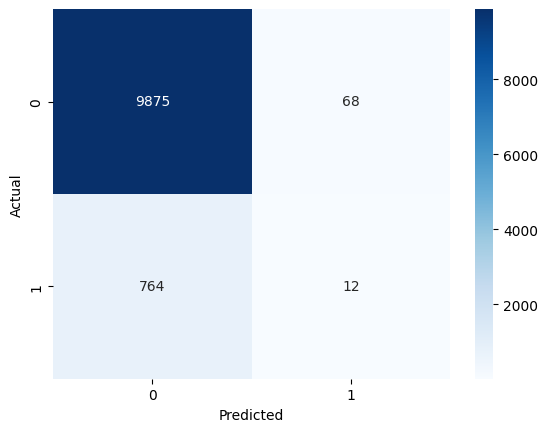

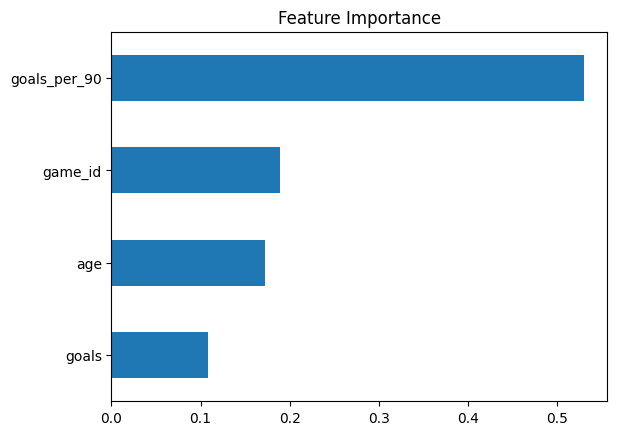

Predicted probability of scoring in opener: 6.50%


In [36]:

# 8. Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 9. Feature importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

# 10. Predicting for the upcoming season opener
# Example: last season's stats
example_player = X.iloc[0:1]
prob = model.predict_proba(example_player)[0][1]
print(f"Predicted probability of scoring in opener: {prob:.2%}")


In [22]:
y_test_int = y_test.iloc[:, 0].astype(int).values
y_pred_int = y_pred[:, 0].astype(int)
